# Feature Basic Filtering

## Purpose
Apply basic filters to remove these problematic features:
- Extremly low coverage or high coverage features
- ENCODE Blcaklist
- Some chromosomes (chrX, chrY and chrM)

## Input
- Cell metadata (after basic cell filter)
- MCDS files

## Output
- FeatureList.BasicFilter.txt: List of feature ids passed all filters

## Import

In [1]:
import yaml
from ALLCools.mcds import MCDS
from wmb import cemba, mm10

## Parameters

In [2]:
with open('config/01.yaml', 'r') as f:
    config = yaml.safe_load(f)
    locals().update(config)
    print('Notebook configs:')
    for _k, _v in config.items():
        print(f'{_k} = {_v}')

Notebook configs:
dataset = mC
exclude_chromosome = ['chrM', 'chrX', 'chrY']
max_cov = 3000
min_cov = 500
select_cells = select_cells.txt


In [3]:
black_list_path = mm10.ENCODE_BLACKLIST_PATH
f = 0.2

if dataset == 'mC':
    mcds_path = cemba.CEMBA_SNMC_MCDS_PATH
else:
    mcds_path = cemba.CEMBA_SNM3C_MCDS_PATH

In [4]:
# Parameters
dataset = "mC"
exclude_chromosome = ["chrM", "chrX", "chrY"]
max_cov = 3000
min_cov = 500
select_cells = "select_cells.txt"


## Load Data

### Metadata

In [5]:
if dataset == 'mC':
    metadata = cemba.get_mc_mapping_metric(select_cells=select_cells)
else:
    metadata = cemba.get_m3c_mapping_metric(select_cells=select_cells)

total_cells = metadata.shape[0]
print(f'Metadata of {total_cells} cells')

Metadata of 12291 cells


In [6]:
metadata.head()

,mCCCFrac,mCGFrac,mCHFrac,FinalmCReads,DissectionRegion,Plate,Col384,Row384,Slice,Sample,Technology,InputReads,PassBasicQC,PlateNormCov
cell,,,,,,,,,,,,,,
14B_M_0,0.006819,0.735136,0.012240,1061284.0,14B,CEMBA210617_14B_1,9,0,14,14B_210617,snmC-seq3,2643012,True,0.945824
14B_M_1,0.007127,0.750066,0.013914,1059639.0,14B,CEMBA210617_14B_1,20,0,14,14B_210617,snmC-seq3,2658348,True,0.944358
14B_M_2,0.007187,0.736750,0.014544,773689.0,14B,CEMBA210617_14B_1,21,0,14,14B_210617,snmC-seq3,1827306,True,0.689518
14B_M_3,0.008106,0.748119,0.014039,1567001.0,14B,CEMBA210617_14B_1,8,0,14,14B_210617,snmC-seq3,3767798,True,1.396523
14B_M_4,0.007109,0.758576,0.021379,1121801.0,14B,CEMBA210617_14B_1,9,1,14,14B_210617,snmC-seq3,3119214,True,0.999758


## Downsample

In [7]:
if metadata.shape[0] > 50000:
    metadata = metadata.sample(50000, random_state=0)

### MCDS

In [8]:
mcds = MCDS.open(mcds_path,
                 var_dim='chrom100k',
                 use_obs=metadata.index)

In [9]:
mcds

<xarray.MCDS>
Dimensions:             (cell: 12291, chrom100k: 27269, count_type: 2,
                         mc_type: 2)
Coordinates:
  * cell                (cell) <U15 '17A_M_2553' '15B_M_3042' ... '17A_M_2837'
  * chrom100k           (chrom100k) <U10 'chr1_0' 'chr1_1' ... 'chrY_917'
    chrom100k_chrom     (chrom100k) <U5 dask.array<chunksize=(4096,), meta=np.ndarray>
    chrom100k_cov_mean  (chrom100k) float64 dask.array<chunksize=(4096,), meta=np.ndarray>
    chrom100k_end       (chrom100k) int64 dask.array<chunksize=(4096,), meta=np.ndarray>
    chrom100k_start     (chrom100k) int64 dask.array<chunksize=(4096,), meta=np.ndarray>
  * count_type          (count_type) <U3 'mc' 'cov'
  * mc_type             (mc_type) <U3 'CHN' 'CGN'
Data variables:
    chrom100k_da        (cell, chrom100k, mc_type, count_type) uint16 dask.array<chunksize=(2458, 4096, 1, 1), meta=np.ndarray>
Attributes:
    obs_dim:  cell
    var_dim:  chrom100k

## Filter Features

### Filter by mean coverage

Using existing chrom100k_cov_mean in MCDS.coords, if this is not desired, delete the existing results by `del mcds.coords["chrom100k_cov_mean"]` and recalculate.


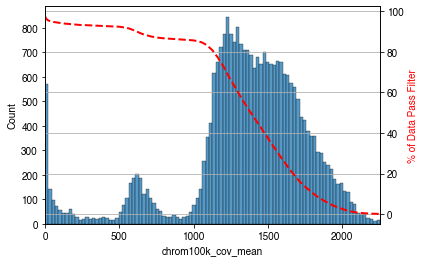

In [10]:
mcds.add_feature_cov_mean()

In [11]:
mcds = mcds.filter_feature_by_cov_mean(
    min_cov=min_cov,  # minimum coverage
    max_cov=max_cov  # Maximum coverage
)

Before cov mean filter: 27269 chrom100k
 After cov mean filter: 25187 chrom100k 92.4%


### Filter by ENCODE Blacklist

In [12]:
mcds = mcds.remove_black_list_region(
    black_list_path=black_list_path,
    f=f  # Features having overlap > f with any black list region will be removed.
)

1166 chrom100k features removed due to overlapping (bedtools intersect -f 0.2) with black list regions.


### Remove chromosomes

In [13]:
mcds = mcds.remove_chromosome(exclude_chromosome)

1410 chrom100k features in ['chrM', 'chrX', 'chrY'] removed.


## Save Feature List

In [14]:
with open('FeatureList.BasicFilter.txt', 'w') as f:
    for var in mcds.get_index(mcds.var_dim).astype(str):
        f.write(var + '\n')